In [1]:
from matplotlib import pyplot as plt
from utils.utils import *
import utils.promethee_functions as pf
import utils.clustering_functions as cf

data = read_data()
K = data.columns.shape[0] # Nb of criteria
L = data.iloc[0]["co2prod"].shape[0] # Length of the time series
N = data.shape[0]

W = [1/K for i in range(K)] # Weights of the criteria (equal weights)
Q = [1, 0.03, 5, 0.01, 0.5, 0.5] # Indifference thresholds
P = [10, 0.4, 20, 0.3, 5, 5]

Weight_vector = [1/L for _ in range(L)] # Equal weights times

utils.py Loading
Reading HDI dataset
co2prod: min=0.0, max=33.3863
hdi: min=0.257, max=0.967
le: min=37.105, max=85.473
gdi: min=0.383, max=1.041
eys: min=3.5751, max=23.2477
mys: min=1.4606, max=14.2559


In [2]:

# group0 = ["PAK", "SDN", "BDI", "HTI"]
# group1 = ["EST", "CZE", "MLT", "SGP", "IRL"]
# group2 = ["CHE", "ISL", "NZL", "SWE"]

# all_groups = group0 + group1 + group2

# data = data.loc[all_groups]
N = data.shape[0]

In [3]:
def dunn_index_multivariate(clusters, data):
    """ 
        Compute the Dunn index for a clustering of multivariate time series data
        - clusters: list of lists of indexes of the time series in each cluster
        - data: the data set (dataframe with index as id of the time series), each cell is a np.array (time series)
    """
    def dunn_index_univariate(clusters, data):
        """
            Compute the Dunn index for a clustering of univariate time series data
            - clusters: list of lists of indexes of the time series in each cluster
            - data: the data set (dataframe with index as id of the time series), only one column where each cell is a np.array (time series)
        """
        centroids = []

        # Define the centroids of the clusters
        for cluster in clusters:
            centroid = np.zeros_like(data.iloc[0])
            for country in cluster:
                centroid += data.loc[country]
            centroid /= len(cluster)
            centroids.append(centroid)

        centroids = np.array(centroids)
        
        # Compute the distances between clusters
        inter_cluster_distances = []
        for i in range(len(clusters)):
            for j in range(i+1, len(clusters)):
                inter_cluster_distances.append(np.linalg.norm(centroids[i] - centroids[j]))

        # Compute the diameter of each cluster
        # Diameter = max distance between two countries in the cluster
        cluster_diameters = []
        for cluster in clusters:
            diameter = 0
            for i in range(len(cluster)):
                for j in range(i+1, len(cluster)):
                    diameter = max(diameter, np.linalg.norm(data.loc[cluster[i]] - data.loc[cluster[j]]))
            cluster_diameters.append(diameter)

        dunn_index = min(inter_cluster_distances) / max(cluster_diameters)
        return dunn_index

    index = 0
    criterias = data.columns

    for criteria in criterias:
        index += dunn_index_univariate(clusters, data[criteria])

    return index / len(criterias)


## 1. P2Kmeans

In [4]:
def p2Kmeans(data, k, W, P, Q, N, K, L, PHI_df):
    """ 
    This function performs the Promethee II method on the data
    Then apply the K-means clustering algorithm on the results
    
    Parameters:
    data (DataFrame): The data to be processed
    W (list): The weights of the criteria
    P (list): The preference function parameters
    Q (list): The indifference function parameters
    K (int): The number of criteria
    L (int): The length of the time series
    """
    results = cf.kMeans(PHI_df, k, max_it=100, distance_function=cf.euclid_distance)

    # Get a list of list of ISO3 codes for each cluster
    clusters = []
    for i in range(k):
        clusters.append(results[i].index.tolist())
    # print(clusters)

    return clusters


## 2. Gamma-Kmedoid

In [5]:
def G_Kmedoid(data, W, P, Q, L, dist_matrix, Weight_vector, k=3, prototype_method="random"):
    """ 
    Function that receives the raw dataset and creates the clusters using the K-Medoid algorithm using Promethee Gamma as the distance matrix
    - data: pd.DataFrame with the raw dataset - iso3 as index and the criteria as columns names
    - W: list of weights for each criteria - must sum to 1
    - P: list of P thresholds for each criteria - must be > 0
    - Q: list of Q thresholds for each criteria - must be >= 0
    - Weight_vector: list of weights for each time point - must sum to 1
    - k: number of clusters to create
    """
    # Verify that the weights sum to 1
    if sum(W) != 1:
        raise ValueError("The weights must sum to 1")
    
    if len(W) != data.shape[1] or len(P) != data.shape[1] or len(Q) != data.shape[1]:
        raise ValueError("The number of weights, P and Q thresholds must be equal to the number of criteria")
    
    # Verify that the P thresholds are > 0
    if any([p <= 0 for p in P]):
        raise ValueError("The P thresholds must be > 0")
    
    # Verify that the Q thresholds are >= 0
    if any([q < 0 for q in Q]):
        raise ValueError("The Q thresholds must be >= 0")
    
    if sum(Weight_vector) != 1:
        raise ValueError("The time weight vector must sum to 1")
    
    if len(Weight_vector) != data.iloc[0]["co2prod"].shape[0]:
        raise ValueError("The time weight vector must have the same length as the time series")

    # Get the criteria names
    alternatives = data.index

    # # Computing the distance matrix
    # phi_c_all = pf.get_all_Phi_c(data, P, Q, L)
    # eta = pf.get_eta_matrix(data, phi_c_all, W, L)
    # agg_eta = pf.aggregate_all_series(eta, Weight_vector)
    # dist_matrix = pd.DataFrame(agg_eta, index=alternatives, columns=alternatives)

    # Run the K-Medoid algorithm
    medoids, clusters, iter = cf.K_Medoid_Eta(alternatives, dist_matrix, k, prototype_method=prototype_method, print_results=False)

    cluster_list = [val for val in clusters.values()]

    # return medoids, clusters
    return cluster_list


## 3. K-means

In [6]:
def KMeans_normal(data, k):
    from tslearn.clustering import TimeSeriesKMeans

    n_clusters = 3


    n_samples = data.shape[0]
    n_features = data.shape[1]

    formatted_data = np.stack([np.stack(data.iloc[:, i].values) for i in range(n_features)], axis=-1)

    names = data.index
    names_formatted = [name for name in names]

    km = TimeSeriesKMeans(n_clusters=n_clusters, metric="euclidean", max_iter=5).fit(formatted_data)
   
    clusters = [[] for _ in range(n_clusters)]
    for i in range(n_samples):
        clusters[km.labels_[i]].append(names_formatted[i])

    return clusters

## 4. Comparison

In [9]:
from tqdm import tqdm

def compare_algorithms(data, k, W, P, Q, N, K, L, Weight_vector, nb_try=10):
    """ 
        Compare the results of the different clustering algorithms on the data and evaluate them using the Dunn index
    """

    # P2Kmeans
    dunn_p2kmeans = []
    phi_c_all = pf.get_all_Phi_c(data, P, Q, L) # compute all mono criterion flows series
    PHI = pf.PHI_all(phi_c_all, W, N, L, K) # Aggregate to the net flow series
    # Transform PHI into a dataframe with ISO3 as index and years as columns
    PHI_df = pd.DataFrame(PHI, index=data.index, columns=np.arange(1990, 2023))
    
    for i in tqdm(range(nb_try), desc="P2Kmeans Progress"):
        results = p2Kmeans(data, k, W, P, Q, N, K, L, PHI_df)
        dunn_p2kmeans.append(dunn_index_multivariate(results, data))

    # G_Kmedoid
    dunn_gkm = []
    # Get the criteria names
    alternatives = data.index

    # Computing the distance matrix
    phi_c_all = pf.get_all_Phi_c(data, P, Q, L)
    eta = pf.get_eta_matrix(data, phi_c_all, W, L)
    agg_eta = pf.aggregate_all_series(eta, Weight_vector)
    dist_matrix = pd.DataFrame(agg_eta, index=alternatives, columns=alternatives)
    for i in tqdm(range(nb_try), desc="G_Kmedoid Progress"):
        results = G_Kmedoid(data, W, P, Q, L, dist_matrix, Weight_vector, k=k)
        dunn_gkm.append(dunn_index_multivariate(results, data))

    # KMeans
    dunn_km = []
    for i in tqdm(range(nb_try), desc="KMeans Progress"):
        results = KMeans_normal(data, k)
        dunn_km.append(dunn_index_multivariate(results, data))

    # KMeans normalized data
    dunn_km_norm = []
    for i in tqdm(range(nb_try), desc="KMeans Normalized Progress"):
        scaled_data = scale_data(data)
        results = KMeans_normal(scaled_data, k)
        dunn_km_norm.append(dunn_index_multivariate(results, data))

    return dunn_p2kmeans, dunn_gkm, dunn_km, dunn_km_norm


k = 6
dunn_p2kmeans, dunn_gkm, dunn_km, dunn_km_norm = compare_algorithms(data, k, W, P, Q, N, K, L, Weight_vector, nb_try=100)


KMeans Normalized Progress: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


C:\Users\raphu\AppData\Local\Temp\ipykernel_30688\1150673038.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([dunn_p2kmeans, dunn_gkm, dunn_km, dunn_km_norm], labels=["P2Kmeans", "G_Kmedoid", "KMeans", "KMeans Normalized"])


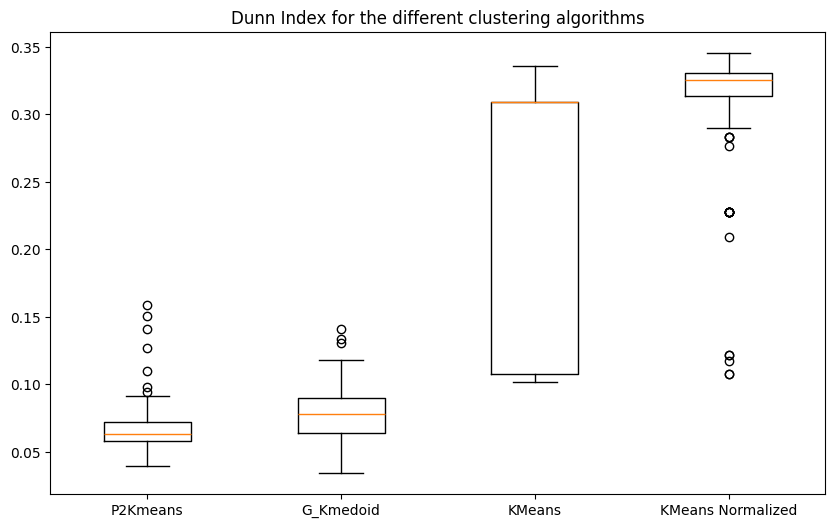

In [10]:
def analyze_results(dunn_p2kmeans, dunn_gkm, dunn_km, dunn_km_norm):
    """
    Analyze the results of the clustering algorithms
    """
    dunn_p2kmeans = np.array(dunn_p2kmeans)
    dunn_gkm = np.array(dunn_gkm)
    dunn_km = np.array(dunn_km)
    dunn_km_norm = np.array(dunn_km_norm)

    # Plot boxplots for each algorithm (on the same plot)
    plt.figure(figsize=(10, 6))

    plt.boxplot([dunn_p2kmeans, dunn_gkm, dunn_km, dunn_km_norm], labels=["P2Kmeans", "G_Kmedoid", "KMeans", "KMeans Normalized"])
    plt.title("Dunn Index for the different clustering algorithms")
    plt.show()

analyze_results(dunn_p2kmeans, dunn_gkm, dunn_km, dunn_km_norm)
